# Evaluating performance of biometric systems
This assignment focusses on evaluating the performance of any biometric system in a verification and identification setting. This assignment will give you insight into the way biometrics systems are evaluated from a performance point of view. Make sure you can properly distinguish the two cases and apply the proper validation procedures. 

* **Verification (a.k.a. authentication)**: authenticating a claimed identity (is this person who he/she claims to be?).

* **Identification**: associate a particular individual with an identity (who is this unidentified individual?)

**The solutions in this assignment are just skeleton examples. Please adapt them where needed.**

Write your code such that you can easily reuse it for the following assignments where you will implement small biometric systems and test them. Many operations have already been implemented in [SciPy](https://docs.scipy.org/doc/numpy/index.html), feel free to use them or any other unless specified otherwise in the assignment.  

In [ ]:
import requests
import zipfile

#Note : This notebook can be directly executed in colab. To do that one needs to set DOWNLOAD_IMAGE to true.

In [ ]:
DOWNLOAD_IMAGE =True

In [ ]:
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [ ]:
if DOWNLOAD_IMAGE:
   share_able_link = "1XTHcjcttWKnNpkLdblD5bbFIHsz9GRAY"
   destination  = "fing_x_fing.zip"
   download_file_from_google_drive(share_able_link, destination)
   share_able_link = "1CRjuwLvB8FltvUyXA2hQZsL8HilZYD37"
   destination  = "BSSR.zip"
   download_file_from_google_drive(share_able_link, destination)
   !unzip "fing_x_fing.zip"
   !unzip "BSSR.zip"

Streaming output truncated to the last 5000 lines.
  inflating: fing_x_fing/sims/dos/ri/V/0046617_02_01.scr.bin  
  inflating: fing_x_fing/sims/dos/ri/V/0046682_02_01.scr.bin  
  inflating: fing_x_fing/sims/dos/ri/V/0046690_02_01.scr.bin  
  inflating: fing_x_fing/sims/dos/ri/V/0046735_02_01.scr.bin  
  inflating: fing_x_fing/sims/dos/ri/V/0046808_02_01.scr.bin  
  inflating: fing_x_fing/sims/dos/ri/V/0046809_02_01.scr.bin  
  inflating: fing_x_fing/sims/dos/ri/V/0046883_02_01.scr.bin  
  inflating: fing_x_fing/sims/dos/ri/V/0047089_02_01.scr.bin  
  inflating: fing_x_fing/sims/dos/ri/V/0047123_02_01.scr.bin  
  inflating: fing_x_fing/sims/dos/ri/V/0047157_02_01.scr.bin  
  inflating: fing_x_fing/sims/dos/ri/V/0047168_02_01.scr.bin  
  inflating: fing_x_fing/sims/dos/ri/V/0047294_02_01.scr.bin  
  inflating: fing_x_fing/sims/dos/ri/V/0047421_02_01.scr.bin  
  inflating: fing_x_fing/sims/dos/ri/V/0047495_02_01.scr.bin  
  inflating: fing_x_fing/sims/dos/ri/V/0047530_02_01.scr.bin  
  in

In [ ]:
# import the required python packages

import numpy as np
import matplotlib.pyplot as plt
# the following meta-command is required to get plots displayed in notebooks
%matplotlib inline

# package for reading xml files
import xml.etree.ElementTree as ET

import os

# package for data analysis with fast and flexible data structures
import pandas as pd

import seaborn as sns

# package to show a nice graphical progress-bar for lengthy calculations
# docu and installation on https://tqdm.github.io
# if you have difficulties installing this package: 
# - make sure your jupyter lab is up to date
# - https://github.com/tqdm/tqdm/issues/394#issuecomment-384743637
# - consider just leaving it out (just remove the 'tqdm_notebook' in the code)
from tqdm.notebook import tqdm as tqdm_notebook

# import local modules for reading and converting BSSR1 fingerprint score data
import BSSR1

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Realistic validation database

For this experiment we will make use of actual fingerprint similarity scores, from the left and right index fingers. This bypasses all steps of preprocessing, feature extraction and matching and allows us to concentrate on the score evaluation procedures. The scores are the result of comparing an enrolled user's image with the score of the same (genuine scores) or another user (imposter scores). 

The data (biometrics scores set BSSR1) are made available through the American National Institute of Standards and Technologies [(NIST)](https://www.nist.gov/itl/iad/image-group/nist-biometric-scores-set-bssr1). They are provided as part of your assignment folder in the fing-x-fing subfolder. 


### Read the BSSR1 scores and convert them to a manageable format

We provide you here with the code to read the scores from the files. Normally you don't need to change this code. 

The scores are first converted to a similarity matrix with the genuine scores on the diagonal and the imposter scores on the off-diagonal elements. For more information on how these data are structured on file, see: [readme](./fing_x_fing/README.html).

Next,if necessary to reduce calculation times, they can be subsampled. 

Finally, the original (subsampled) scores are converted to a linear list of scores with associated labels of genuine or imposter, which simplifies their use in [scikit-learn](https://scikit-learn.org/stable/index.html) for evaluation.

In [ ]:
## provide links to the relevant files

# set paths to files containing identity tags of enrollees and users
li_enrollees_id_filepath = './fing_x_fing/sets/dos/li/enrollees.xml'
li_users_id_filepath = './fing_x_fing/sets/dos/li/users.xml'
# set list string for scores files
li_scores_list_str = './fing_x_fing/sims/dos/li/V/*.bin'

ri_enrollees_id_filepath = './fing_x_fing/sets/dos/ri/enrollees.xml'
ri_users_id_filepath = './fing_x_fing/sets/dos/ri/users.xml'
# set list string for scores filesr
ri_scores_list_str = './fing_x_fing/sims/dos/ri/V/*.bin'

In [ ]:
# read BSSR1 scores (this might take a while)
(li_fingxfing_dataframe, li_enrollees, li_users, li_column_names) = BSSR1.read_BSSR1_scores_from_file(li_enrollees_id_filepath, li_users_id_filepath, li_scores_list_str)

In [ ]:
(ri_fingxfing_dataframe, ri_enrollees, ri_users, ri_column_names) = BSSR1.read_BSSR1_scores_from_file(ri_enrollees_id_filepath, ri_users_id_filepath, ri_scores_list_str)

In [ ]:
# subsample the scores to a manageable number of individuals
li_similarity_matrix = BSSR1.df2sim_subsample(li_fingxfing_dataframe, column_names = li_column_names, nr_individuals = 1000)

In [ ]:
# subsample the scores to a manageable number of individuals
ri_similarity_matrix = BSSR1.df2sim_subsample(ri_fingxfing_dataframe, column_names = ri_column_names, nr_individuals = 1000)

In [ ]:
# convert to genuine and imposter scores, the *_genuine_id provides a mask for the genuine scores
li_genuine_id, li_scores = BSSR1.sim2scores(li_similarity_matrix)

In [ ]:
# convert to genuine and imposter scores, the *_genuine_id provides a mask for the genuine scores
ri_genuine_id, ri_scores = BSSR1.sim2scores(ri_similarity_matrix)

In [ ]:
import collections

In [ ]:
def normalize_x(x,min_X,max_X):
     return ((x-min_X)/(max_X - min_X))


We first add the values to different list for efficiently computing.

In [ ]:
def split_distributions(scores,ids):
    genuine_score = []
    imposter_score = []
    for i in range(len(scores)):
        if(ids[i] == 1):
            genuine_score.append(scores[i])
        else:
            imposter_score.append(scores[i])
    return (genuine_score,imposter_score)



In [ ]:
(li_genuine_score,li_imposter_score) = split_distributions(li_scores,li_genuine_id)
(ri_genuine_score,ri_imposter_score) = split_distributions(ri_scores,ri_genuine_id)

Generate two different lists for imposter and geniune id.

## Validation of verification system
In an authentication scenario, one has a binary classification problem: is it the claimed identity or not? We thus have two classes: genuine and imposter

### Evaluation using FMR, FRR, ROC and Precision/Recall curves

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)

The performance of these systems can be expressed in a number of ways (see [Jain et al.][1] section 1.4.1.1). 

#### 1. Genuine and imposter score distributions

From the previously calculated genuine and impostor scores for the available data, first generate and plot the genuine and impostor score distributions: 

<p align="center">
    <img src="img/ScoreDistributions.png" width="250" height="auto"/>
</p>



#### <font color=blue> Task 1.1 Plot and describe the score distributions

* Plot the genuine and imposter score distributions in a single plot.
* Do you need to normalize the distributions? Why (not)?
* Describe qualitatively this combined plot (hint: limit the score range for better understanding)
</font>

#### We now plot the distribution for both fingers.

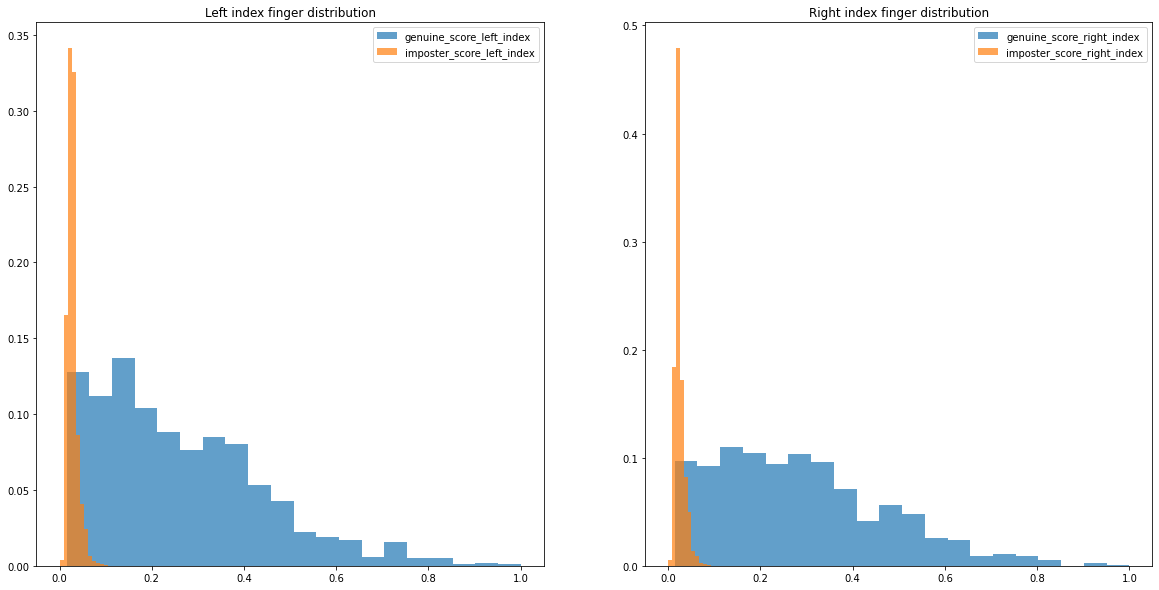

In [ ]:
#Set the size of the figure.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
#First create the weights for normalized version of the plots.
weights = np.ones_like(li_genuine_score)/float(len(li_genuine_score))
weights2 = np.ones_like(li_imposter_score)/float(len(li_imposter_score))
#Parameters that define type of the curve and number of bins.
kwargs = dict(histtype='stepfilled', alpha=0.7,  bins=20)
#Finally plot the histogram.
axes[0].hist(li_genuine_score,**kwargs, weights=weights,label = 'genuine_score_left_index')
axes[0].hist(li_imposter_score,**kwargs, weights=weights2,label = 'imposter_score_left_index')
axes[0].title.set_text('Left index finger distribution')
axes[0].legend()
weights_right = np.ones_like(ri_genuine_score)/float(len(ri_genuine_score))
weights_rioght_2 = np.ones_like(ri_imposter_score)/float(len(ri_imposter_score))
axes[1].hist(ri_genuine_score,**kwargs, weights=weights,label = 'genuine_score_right_index')
axes[1].hist(ri_imposter_score,**kwargs, weights=weights2,label = 'imposter_score_right_index')
axes[1].title.set_text('Right index finger distribution')
axes[1].legend()
plt.show()

#####These distributions are hard to interpret in terms of threshold. We can normalize these plot separately to get better view of threshold. 

##### In next section, we will plot the curves such that we can find the threshold where both distribution interpret eachother.

We add a function that will plot two distributions.

In [ ]:
import collections
import scipy.stats as stats
import scipy
import matplotlib.mlab as mlab
from matplotlib.ticker import StrMethodFormatter, NullFormatter

def plot_distributions(genuins_score,imposter_score,text,col):
    fig,(ax1,ax2,ax3) = plt.subplots(1,3, sharey=False, sharex=False,figsize=(20,8))
    g = sns.distplot(genuins_score,hist=True, ax=ax1,kde=True, rug=False,label='G_score',color='r')
    g2 = sns.distplot(imposter_score,hist=True, ax=ax2,kde=True, rug=False,label='I_score',color='r')
    ax2.set_xlim(0,1)
    ax2.set_title('Partially-Normalized plot of imposter score',color='g')
    ax1.set_title('Partially-Normalized plot of genuine score',color='g')
    ax1.set_xlabel("Threshold/scores")
    ax1.set_ylabel("Frequency")
    ax2.set_xlabel("Threshold/scores")
    ax2.set_ylabel("Frequency")
   # get distplot line points
    line = g.get_lines()[0]
    xd = line.get_xdata()
    yd = line.get_ydata()
    def normalize(x):
        return (x - x.min(0)) / x.ptp(0)
    #normalize points
    yd2 = normalize(yd)
    #second curve
    line_s = g2.get_lines()[0]
    xd_s = line_s.get_xdata()
    yd_s = line_s.get_ydata()
    #normalize points
    yd_s = normalize(yd_s)
    # plot them in another graph
    ax3.plot(xd,yd2,label="genuine-distribution",linestyle="-",color='b')
    ax3.fill(xd,yd2,'b', alpha=0.3)
    ax3.set_title('Normalized plot of imposter and genuine score',color='blue')
    ax3.plot(xd_s,yd_s,label="imposter-distribution",linestyle="-",color='r')
    ax3.fill(xd_s,yd_s,'b', alpha=0.5)
    ax3.set_xlabel("Threshold/scores")
    ax3.set_ylabel("Frequency")
    ax3.set_xlim(0,0.8)
    ax3.legend()
    fig.suptitle("Distributions of " + text, fontsize=16,color=col)
    plt.show()


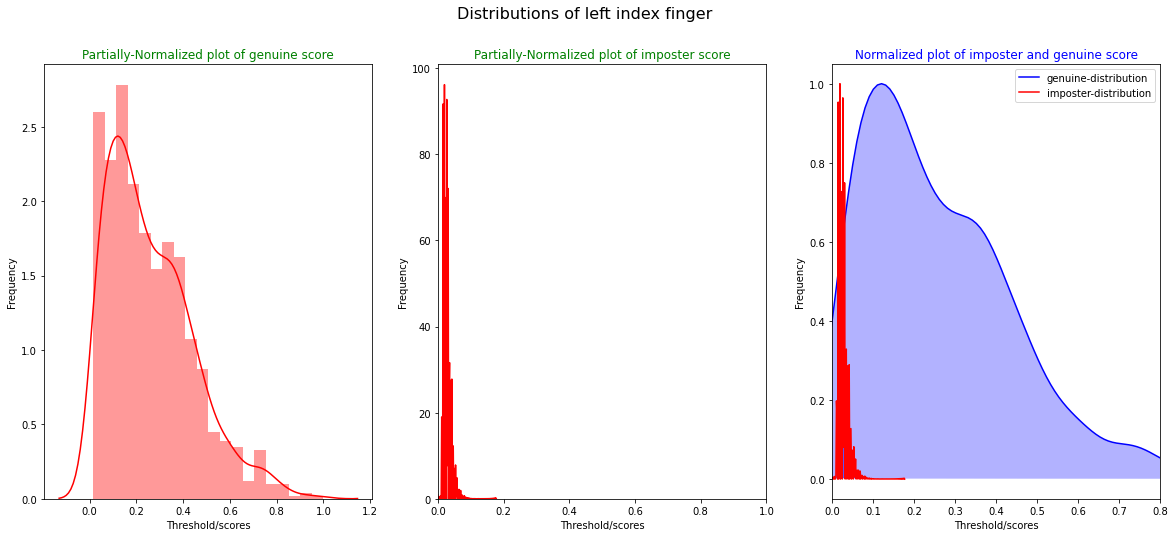

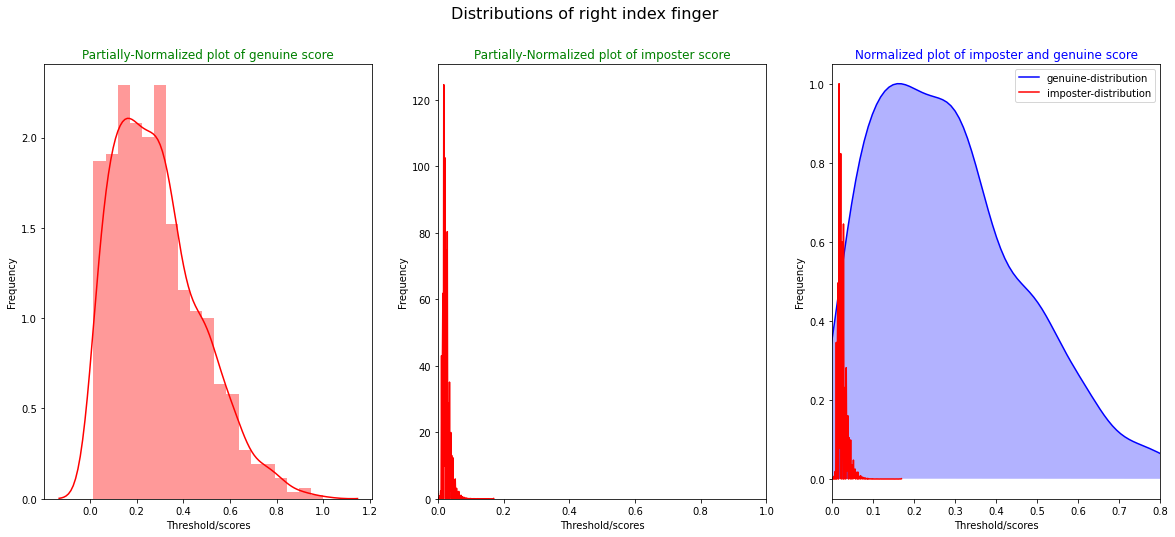

In [ ]:
"""Plot the genuine and imposter score distributions."""
plot_distributions(li_genuine_score,li_imposter_score,"left index finger",'black')
plot_distributions(ri_genuine_score,ri_imposter_score,"right index finger",'black')


# Normalizing the plot

We need to normalize the plot otherwise the frequency at a specific score/threshold  of one distribution are very high in camparison to other one. Imposter distribution has very high frequency between the scores 0.0 and 0.2 and this creates a problem while ploting the distribution.

Another problem is that if we normalize both distributions together then we are simply squashing all the values with same factor. In this case, there is no advantage of normalizing. To get a better overview, we have normalized both distributions seperately. It provides better overview to determine a boundary but the y-axis does not provide enough information.


# Descirbing the plot qualitively.

First,we need to mention again that two plots were normalized seperately. From the peaks,we can only infer where the most values lie in individual distributions. However, comparing the peaks between two distributions will only make sense if we want to know, how far(on the x-axis) do the two distributions have their highest value. It is not possible to know by what percentage one distribution has more values in an interval in comparison to other distribution(drawback of normalizing seperately).

From the figures, it can be seen that imposter distribution lies in a very restricted region(scores < 0.2). If we want to avoid false positive then we can choose a threshold at 0.2. We can also notice that at this threshold, genuine distribution has highest peak(indicates that more values lie there).

A value greater than 0.2, can create many false negatives because at this value, we have highest peak in genuine distribution.
A value between 0.1 and 0.2 is a tradeoff between false positives and false negatives.

#### 2. FMR, FRR and Receiver Operating Characteristic (ROC) curve

False Match/Acceptance Rates (FMR/FAR), False Non-Match/Rejections Rates (FNMR/FRR) and Genuine Acceptance Rate (GAR)/True Match Rate (TMR) are calculated given the impostor $p(s | I)$ and genuine $p(s | G) $ probability distributions for every match score threshold value $\eta$. 

Given a set of match scores corresponding to the genuine class G and a set of match scores from the imposter class I this comes down to a counting problem, having $\mathcal{I}$ the indicator function (return 1 if x is true, else 0) we can compute
$$
FMR(\eta) = p(s \geq \eta | I) \approx \frac{1}{|I|} \sum_{s \in I} \mathcal{I}(s \geq \eta) 
$$
$$
FRR(\eta) = p(s < \eta | G) \approx \frac{1}{|G|} \sum_{s \in G} \mathcal{I}(s \geq \eta) 
$$
$$
GAR(\eta) = p(s \geq \eta | G) = 1 - FRR(\eta)
$$

<img src="img/FAR_FRR.png" width="300" height="auto" align="center"/>

To observe the impact of the threshold value, one often plots a ([Receiver Operating Characteristic (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)) curve. Usually in these curves the GAR/TMR is plotted against the FMR for different decision threshold values $\eta$. For those familiar with binary classification systems outside of the biometrics literature; the GAR/TMR is often referred to as the True Positive Rate (TPR),  sensitivity or recall and FMR is also known as the False Positive Rate (FPR) or the False Accept Rate (FAR). 

<img src="img/ROC.png" width="400" height="auto" align="center"/>

#### <font color=blue> Task 1.2 Plot and discuss ROC curve 

* Calculate FPR, TPR from the matching scores.
* Plot FAR and FRR as a function of matching scores.
* Plot the ROC curve. Plot for linear and logarithmic scale if needed. What do you observe? 
* Plot the Detection Error Trade-off (DET) curve. How does it compare to ROC?

Use the [scikit-learn](https://scikit-learn.org/stable/index.html) package, which contains standard and advanced routines for machine learning, including classificaton and validation algorithms.
</font>

In [ ]:
"""Calculate FPR, TPR from the matching scores."""

from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn import metrics
li_fpr, li_tpr, li_thresholds = roc_curve(li_genuine_id, li_scores)
ri_fpr, ri_tpr, ri_thresholds = roc_curve(ri_genuine_id, ri_scores)

Next, we compute FMR & FRR for the left index finger. To do that, we define a function that counts for each possible scores, number of values which are higher than that value.

In [ ]:
def get_list_of_increasing_number(scores,list_of_dist_vals):
    previous_j = 0
    previous_sum = 0
    total_greater_values = 0
    len_of_scores = len(scores)
    len_of_dist_list = len(list_of_dist_vals)
    to_return_list = []
    for i in range(len_of_scores):
        total_greater_values = previous_sum
        for j in range(previous_j,len_of_dist_list):
            if(list_of_dist_vals[j] >= scores[i]):
                total_greater_values = total_greater_values + 1
            elif(list_of_dist_vals[j] < scores[i]):
                previous_j = j
                previous_sum = total_greater_values
                break
        normalized = ((total_greater_values))/len_of_dist_list
        to_return_list.append(normalized)
    return to_return_list

Next we make a setup and call the function defined above to return us number of values which are greater than each score(normalized).

In [ ]:
removed_dup_scores = list(set(li_scores))
sorted_score_li = sorted(removed_dup_scores,reverse=True)
sorted_imposter_li = sorted(li_imposter_score,reverse=True)
sorted_li_genuine_score = sorted(li_genuine_score,reverse=True)
FMR_list = get_list_of_increasing_number(sorted_score_li,sorted_imposter_li)
FRR_list = get_list_of_increasing_number(sorted_score_li,sorted_li_genuine_score)
FRR_list.sort(reverse=True)

We repeat same procedure as above for right index finger.

In [ ]:
removed_dup_scores_ri = list(set(ri_scores))
sorted_score_ri = sorted(removed_dup_scores_ri,reverse=True)
sorted_imposter_ri = sorted(ri_imposter_score,reverse=True)
sorted_ri_genuine_score = sorted(ri_genuine_score,reverse=True)
FMR_list_ri = get_list_of_increasing_number(sorted_score_ri,sorted_imposter_ri)
FRR_list_ri = get_list_of_increasing_number(sorted_score_ri,sorted_ri_genuine_score)
FRR_list_ri.sort(reverse=True)

We now plot the curves for right and left index finger.

In [ ]:
"""Plot FAR and FRR as a function of matching scores."""
def plot_FMR_FRR(sorted_score_li,FMR_li,FRR_li,sorted_score_ri,FMR_ri,FRR_ri,bool_val):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    first_plot, = axes[0].plot(sorted_score_li,FMR_li,color='RED',label='FMR',marker=".")
    axes[0].legend(loc="upper right")
    second_plot, = axes[0].plot(sorted_score_li,FRR_li,color='BLUE',label='FRR',marker=".")
    axes[0].legend(loc="upper right")
    axes[0].title.set_text("Left index FMR & FRR")
    axes[0].set_xlabel('Scores/Threshold')
    axes[0].set_ylabel('% FMR or FRR')
    first_plot, = axes[1].plot(sorted_score_ri,FMR_ri,color='RED',label='FMR',marker=".")
    axes[1].legend(loc="upper right")
    second_plot, = axes[1].plot(sorted_score_ri,FRR_ri,color='BLUE',label='FRR',marker=".")
    axes[1].legend(loc="upper right")
    axes[1].title.set_text("Right index FMR & FRR")
    axes[1].set_xlabel('Scores/Threshold')
    axes[1].set_ylabel('% FMR or FRR')
    if(bool_val):
        axes[1].set_xscale('log')
        axes[0].set_xscale('log')
        axes[0].set_xlabel('Scores/Threshold in log scale')
        axes[1].set_xlabel('Scores/Threshold in log scale')
    plt.show()

In [ ]:
FMR_li = FMR_list
FRR_li = FRR_list
FMR_ri = FMR_list_ri
FRR_ri = FRR_list_ri

We will plot the FMR vs FRR in linear scale and also on logarithmic scale.

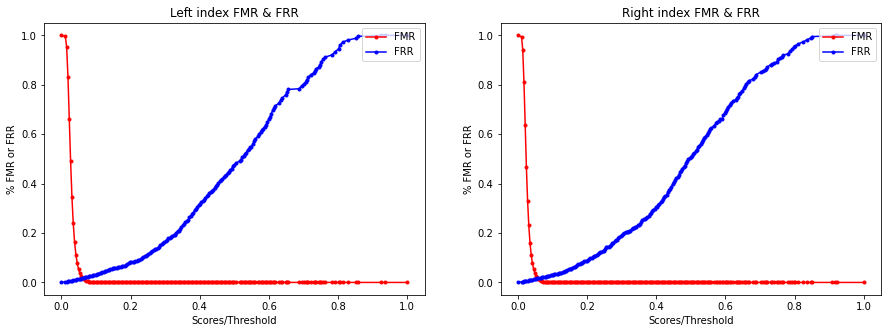

In [ ]:
plot_FMR_FRR(sorted_score_li,FMR_list,FRR_list,sorted_score_ri,FMR_list_ri,FRR_list_ri,False)

From the above curves,it is not clear what threshold to choose. We can improve this situation by plotting the curves in logarithmic scale.

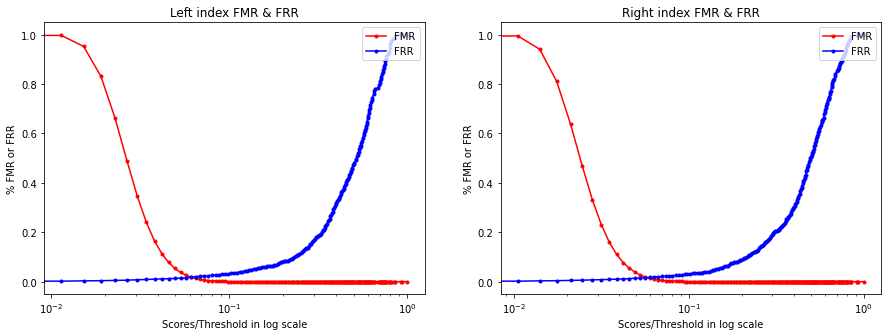

In [ ]:
plot_FMR_FRR(sorted_score_li,FMR_list,FRR_list,sorted_score_ri,FMR_list_ri,FRR_list_ri,True)

# Now we define a function that will draw ROC curves.

In [ ]:
def plot_roc_curve(fpr, tpr,fpr2,tpr2,label,label2,bool_val):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    axes[0].plot(fpr, tpr, color='Red', label=label,marker="*")
    axes[1].plot(fpr2, tpr2, color='Blue', label=label2,marker="*")
    axes[0].plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    axes[1].plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    axes[0].set_xlabel('False Positive Rate')
    axes[1].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[0].set_title("(ROC) Curve of " + label)
    axes[1].set_title("(ROC) Curve of " + label2)
    if(bool_val):
        axes[0].set_xscale('log')
        axes[1].set_xscale('log')
        axes[0].set_xlabel('False Positive Rate in log scale')
        axes[1].set_xlabel('False Positive Rate in log scale')
    plt.legend()
    plt.show()

#### We plot the roc curve with the FPR and TPR that we calculated in the first section.

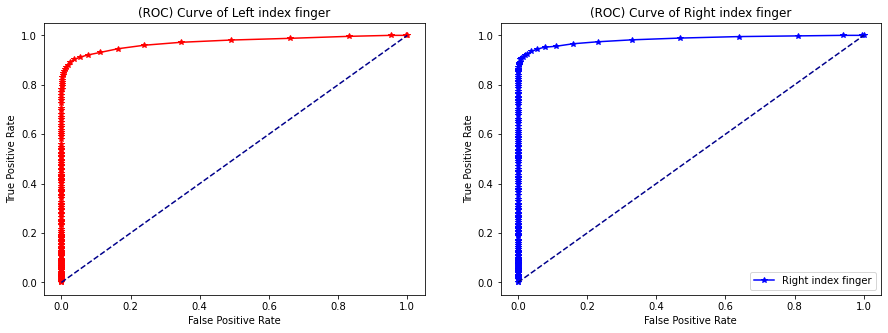

In [ ]:
"""plot the ROC curve (TPR against the FPR for different threshold values)"""
from sklearn import metrics
plot_roc_curve(li_fpr,li_tpr,ri_fpr,ri_tpr,"Left index finger","Right index finger",False)


#### Again we see that these plot do not provide good overview between 0.0 and 0.2. So we transform the x-axis in logarithmic scale.

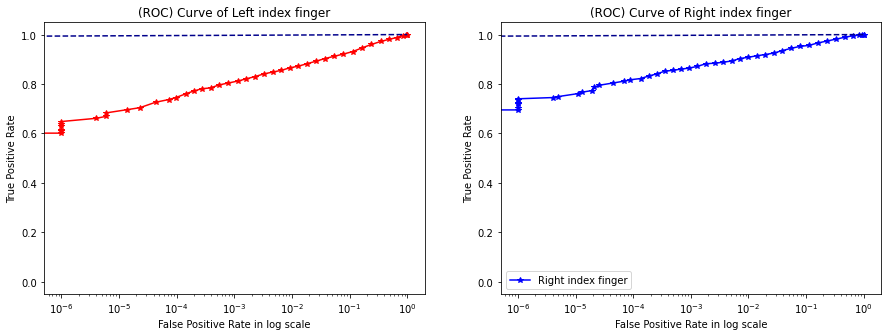

In [ ]:
plot_roc_curve(li_fpr,li_tpr,ri_fpr,ri_tpr,"Left index finger","Right index finger",True)

##### In ROC curves, TPR is plotted along the Y-axis while False positive rate is plotted along the x-axis. Hence, we want a curve which is more shifted towards upper left corner. On the other hand, if the a classifier's point lie on the diagonal line then it's behaviour is random. If the classifier's point lie below the diagonal line then it does opposite of what it should do.(Classifies each positive example a negative and negative examples as positives). We aim to maximize the area under the curve.

## In the next section, we will plot DET curves.

### In DET curves, we plot FRR on the x-axis while FMR on y-axis.

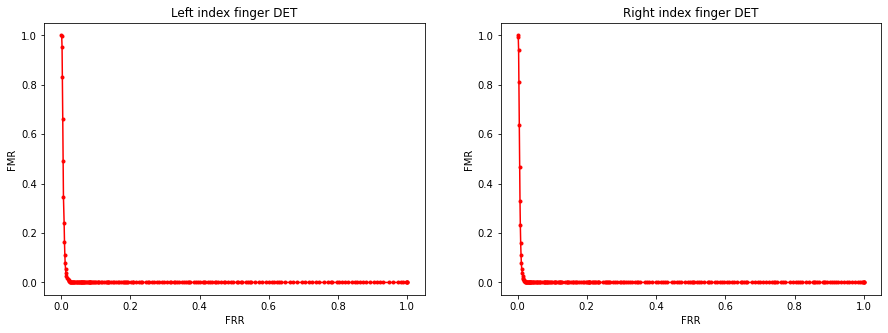

In [ ]:
"""plot the DET curve (FRR (=1-tpr) against the FAR for different threshold values)"""
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(FRR_list,FMR_list,color="RED",marker=".",label='DET')
axes[0].set_xlabel("FRR")
axes[0].set_ylabel("FMR")
axes[0].title.set_text("Left index finger DET")
axes[1].plot(FRR_list_ri,FMR_list_ri,color="Red",marker=".",label='DET')
axes[1].title.set_text("Right index finger DET")
axes[1].set_xlabel("FRR")
axes[1].set_ylabel("FMR")
plt.show()


### DET VS ROC

Since, we know FMR is equivalent to FPR and FRR is equivalent to FNR. DET curves are ROC-curves but rotated by $-90$ degree. In ROC we try to maximize the area(try to move towards upper left corner) while in DET curves we try to minimize the area because now we have errors on both axis.

#### 3. F1 and accuracy as metrics

While biometric systems are, traditionally, evaluated using FMR and FRR and ROC/DET curves, we can also have a look at traditional [classification metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) such as classification accuracy (or error) and F1 measure. 

#### <font color=blue> Task 1.3 Calculate and discuss F1 and accuracy

* Plot F1 and accuracy as a function of the decision thresholds on the similarity score.
 * Interpret these two curves.
* Calculate the threshold for which F1 is maximal. 
 * Is it an interesting operating point?
 * What is the accuracy for this operating point? 
* Do the same for the classification error (or accuracy).
 * is there any difference between the two settings? Why(not)?
* Is accuracy a good performance measure for this case? Why(not)?

Use the scikit-learn [classification metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) to assist.
</font>

We start by importing classification metrics.

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

We add a function that when given a threshold, returns the value 0 or 1 after comparing the threshold to the scores. We need these value to build a vector(which we will call predicted vector). We will use this vector with the actual id vector to use the already existing functions from sklearn.

In [ ]:
def get_predicted_labels(threshold,score):
    if(score >= threshold):
        return 1
    else:
        return 0
    

Now we generate $50$ random thresholds that will be used in next section.

In [ ]:
thresholds = []
threshold = 0.001
step = 0.002
for i in range(1,50):
    thresholds.append(threshold)
    threshold = threshold + step

Now we need a function that will compute accuracy or F-score depending on the input arguments. We will use these values to plot the accuracy or F-score curves.

In [ ]:
def get_performance_metrics(y_true,scores,thresholds,text):
    len_of_li_scores = len(scores)
    len_of_thresholds = len(thresholds)
    values = []
    for i in range(len_of_thresholds):
        li_predicted_labesl = []
        for j in range(len_of_li_scores):
            li_predicted_labesl.append(get_predicted_labels(thresholds[i],scores[j]))                
        assert(len(li_predicted_labesl) == len_of_li_scores)
        if(text == "acc"):
            values.append(accuracy_score(y_true, li_predicted_labesl))
        elif(text == "F1"):
            values.append(f1_score(y_true, li_predicted_labesl,average='macro'))
    return values


Finally, call this function to compute accuracy and save the results in two lists. This takes a while.

In [ ]:
"""Plot F1 and accuracy as a function of the decision thresholds on the similarity score."""
# Hint: evaluating for ± 50 threshold values should suffice
accuracy_li = get_performance_metrics(li_genuine_id,li_scores,thresholds,"acc")
accuracy_ri = get_performance_metrics(ri_genuine_id,ri_scores,thresholds,"acc")

Next we plot the accuracy.

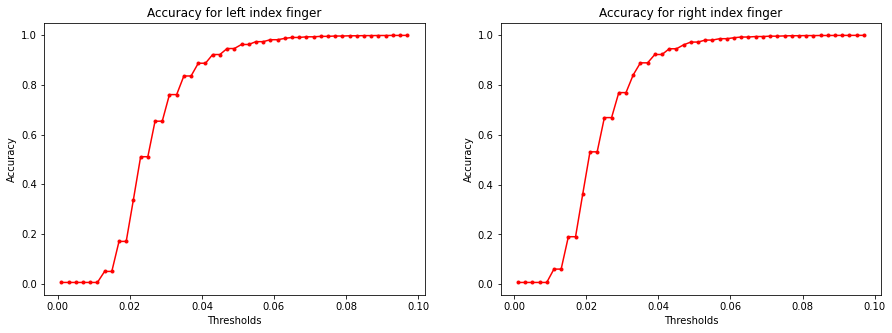

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(thresholds,accuracy_li,color="RED",marker=".",label='Acc')
axes[0].set_xlabel("Thresholds")
axes[0].set_ylabel("Accuracy")
axes[0].title.set_text("Accuracy for left index finger")
axes[1].plot(thresholds,accuracy_ri,color="RED",marker=".",label='Acc')
axes[1].set_xlabel("Thresholds")
axes[1].set_ylabel("Accuracy")
axes[1].title.set_text("Accuracy for right index finger")
plt.show()

In [ ]:
print("The length of genuine scores for left index " , len(li_genuine_score))
print("The length of imposter scores for left index " , len(li_imposter_score))
print()
print("The length of genuine scores for right index " , len(ri_genuine_score))
print("The length of imposter scores for right index " , len(ri_imposter_score))

The length of genuine scores for left index  1000
The length of imposter scores for left index  999000

The length of genuine scores for right index  1000
The length of imposter scores for right index  999000


From the initial distribution plot, we know that the max score of imposter is $<0.2$. The accuracy should change a lot in this region. However,accuracy is also changing outside this region until it reaches saturation point.  We see that two classes are highly imbalanced. 

Accuracy is a simple metric. On x-axis we have threshold while on y-axis a value which is equal to $= \frac{TP+TN}{TP+TN+FP+FN}$

# In this section, we compute the f-score and also plot it.

#### We will use sklearn library to compute the f-score. To do so, we need a predicted vector. We use same function that we used in previous section to build such vector. However, we will pass as argument "F1" so that F-score gets computed instead of accuracy

We first modify thresholds for F1-score and then calculate it.

In [ ]:
thresholds = []
threshold = 0.001
step = 0.01
for i in range(1,100):
    thresholds.append(threshold)
    threshold = threshold + step

Now we get the values for F1-score from the function from previous section.

In [ ]:
f1_li = get_performance_metrics(li_genuine_id,li_scores,thresholds,"F1")
f1_ri = get_performance_metrics(ri_genuine_id,ri_scores,thresholds,"F1")

Next, we plot F-scores.

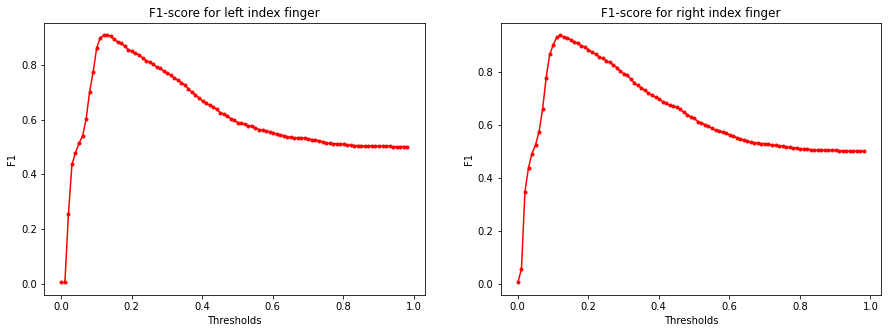

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(thresholds,f1_li,color="RED",marker=".",label='F1')
axes[0].set_xlabel("Thresholds")
axes[0].set_ylabel("F1")
axes[0].title.set_text("F1-score for left index finger")
axes[1].plot(thresholds,f1_ri,color="RED",marker=".",label='F1')
axes[1].set_xlabel("Thresholds")
axes[1].set_ylabel("F1")
axes[1].title.set_text("F1-score for right index finger")
plt.show()

In previous section, we saw that accuracy went up to $99\%$ and  does not decrease any further. This is because once we have seen all the data,accuracy will not be less than the highest value. We have $99\%$ values in one distribution while $1\%$ values in other distribution. 

F-score is weighted average of precision and recall. Precision tells us, out of all positive predicted instances, what fraction are actually positive while recall tells us that out of all actual positive instance, what fraction did we predict as positive.

Increasing the threshold will result in higher precision while decreasing the threshold will result in high recall. We see in the figure(F-score) that the curves start decreasing after reaching the max point. 

As discussed earlier, at this point all the imposter instances are correcyly classified while few genuine scores may also get reject but if we move further then recall will keep decreasing and precision will not increase because there are no more imposter scores.

In [ ]:
"""Calculate the threshold for which F1 is maximal."""

"""Max value for left index finger"""
index_left_finger = f1_li.index(max(f1_li))

"""Max value for right index finger"""
index_right_finger = f1_ri.index(max(f1_ri))

print("F-score for left index finger is maximum at " ,"{:.2f}".format(round(thresholds[index_left_finger], 2)))
print()
print("F-score for right index finger is maximum at " ,"{:.2f}".format(round(thresholds[index_right_finger], 2)))




F-score for left index finger is maximum at  0.13

F-score for right index finger is maximum at  0.12


We see that we have f-score at a point were our distributions intersect each other(from second time starting from zero). At this point, there is good tradeoff between precision and recall.

In [ ]:
"""Do the same for the classification error (or accuracy)"""

"""Max value for left index finger"""
index_left_finger = accuracy_li.index(max(accuracy_li))

"""Max value for right index finger"""
index_right_finger = accuracy_ri.index(max(accuracy_ri))

print("Accuracy for left index finger is maximum at " ,"{:.2f}".format(round(accuracy_li.index(max(accuracy_li)), 2)))
print("Accuracy for right index finger is maximum at " ,"{:.2f}".format(round(accuracy_ri.index(max(accuracy_ri)), 2)))
print()

print("Accuracy at 48 for left index ","{:.2f}".format(round(accuracy_li[48], 2)))
print("Accuracy at 47 for right index ","{:.2f}".format(round(accuracy_ri[47], 2)))
print()


print("Accuracy at 45 for left index ","{:.2f}".format(round(accuracy_li[45], 2)))
print("Accuracy at 45 for right index ","{:.2f}".format(round(accuracy_ri[45], 2)))


Accuracy for left index finger is maximum at  48.00
Accuracy for right index finger is maximum at  47.00

Accuracy at 48 for left index  1.00
Accuracy at 47 for right index  1.00

Accuracy at 45 for left index  1.00
Accuracy at 45 for right index  1.00


From the above printed details, we can see that accuracy reaches $100\%$ before $48$. We have two classes , namely imposter and genuine. We have $99\%$ instances in imposter class and $1\%$ instances genuine class. All the imposter scores lie before (0.2 approximately) and once we have seen this threshold,after that accuracy will not decrease because it classifies $99\%$ of the instances correctly. Since, genuine distribution is dispersed between $0$ and $1$ accuracy reaches approximately $100\%$.

#### 4. AUC and EER as summary measures

The overall performance (over all threshold settings) is typically expressed through:

* The Area Under the Curve (AUC) (with TPR((y-axis) vs FPR (x-axis))

<img src="img/AUC.png" width="250" height="auto"/>

The AUC can be used to compare different systems. The larger this number, the better.
However, since it is a summary measure, always inspect the full ROC curve to make decisions about performance given operating conditions (in wich FRR, FAR regime to work e.g.).

* The Equal Error Rate (EER), which is the point on the ROC-curve where FAR(FMR) equals FRR (1-TAR). A lower EER value indicates better performance. 

<img src="img/EER.png" width="300" height="300"/>

#### <font color=blue> Task 1.4 Calculate and discuss AUC and EER and alternatives

* Calculate ROC AUC. 
 * Does it reveal anything about the performance of the system?
* Calculate (by approximation) the EER and plot it on the FAR-FRR curve.
 * Would you consider this a good operating point?
* Calculate the decision threshold for which the sum of FRR and FAR is minimal. 
 * Is it similar to the total classification error?
* Can you suggest other strategies that give you an "optimal" performance? Calculate and discuss their (de)merits.
        
</font>

We will use sklearn and initially given ID vector and scores to compute auc.

In [ ]:
"""Calculate the ROC AUC."""
from sklearn.metrics import roc_auc_score

"""AUC for left index finger"""
auc_li = roc_auc_score(li_genuine_id, li_scores)
auc_ri = roc_auc_score(ri_genuine_id, ri_scores)

print("AUC score for left index finger is " ,auc_li)
print()
print("AUC score for left index finger is " ,auc_ri)

AUC score for left index finger is  0.9712470650650651

AUC score for left index finger is  0.9826611286286288


AUC score does not tell us about the optimal threshold. It is possible that a classifier has lower auc but out performs other classfier for a specific threshold. However, the total area(auc) captured by roc-curve does not change. Only AUC is not useful since we can't choose a threshold.

In [ ]:
"""Calculate (by approximation) the EER and plot it on the FAR-FRR curve."""
# hints:
#  - you can use an interpolated or discrete approximation, both are fine
#  - avoid using a library for this assignment 

index_EER_li = -1
index_EER_ri = -1
for i in range(len(FMR_li)):
    if FMR_li[i] >= FRR_li[i]:
       index_EER_li = i
       break
for i in range(len(FMR_ri)):
    if FMR_ri[i] >= FRR_ri[i]:
       index_EER_ri = i
       break

In [ ]:
point_li = pd.DataFrame({'x': [sorted_score_li[index_EER_li]], 'y': [(FMR_li[index_EER_li]+FRR_li[index_EER_li])/2]})
point_ri = pd.DataFrame({'x': [sorted_score_ri[index_EER_ri]], 'y': [(FMR_ri[index_EER_ri]+FRR_ri[index_EER_ri])/2]})


/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  fig.canvas.print_figure(bytes_io, **kw)


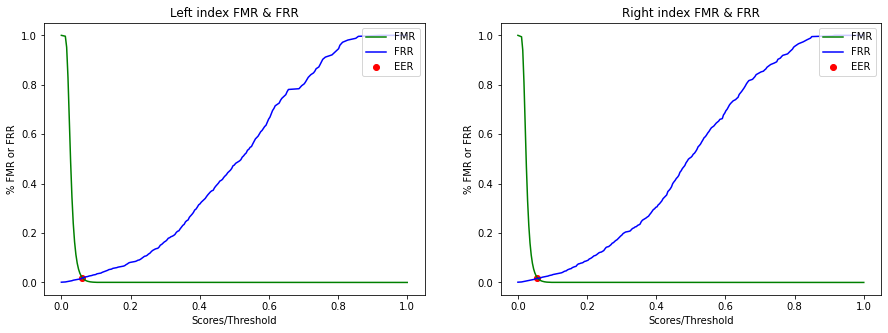

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].scatter(point_li['x'], point_li['y'], marker='o', color='r', label='EER')
axes[0].legend(loc='upper left')
axes[0].plot(sorted_score_li,FMR_li,color="G",marker="",label='FMR')
axes[0].plot(sorted_score_li,FRR_li,color="BLUE",marker="",label='FRR')
axes[0].legend(loc="upper right")
axes[0].title.set_text("Left index FMR & FRR")
axes[0].set_xlabel('Scores/Threshold')
axes[0].set_ylabel('% FMR or FRR')
first_plot, = axes[1].plot(sorted_score_ri,FMR_ri,color='G',label='FMR',marker="")
axes[1].scatter(point_ri['x'], point_ri['y'], marker='o', color='r', label='EER')
axes[1].legend(loc="upper right")
second_plot, = axes[1].plot(sorted_score_ri,FRR_ri,color='BLUE',label='FRR',marker="")
axes[1].legend(loc="upper right")
axes[1].title.set_text("Right index FMR & FRR")
axes[1].set_xlabel('Scores/Threshold')
axes[1].set_ylabel('% FMR or FRR')
plt.show()

##### EER shows a points where FMR and EER intersect eachother and hence that point can be used for picking the threshold.

In [ ]:
"""Calculate the decision threshold for which the sum of FRR and FAR is minimal."""
# hint: same as above
def get_minimal_sum(FMR,FRR):  
    sum_frr = 0
    sum_fmr = 0
    min_vals = []
    for i in range(len(FMR)):
        sum_fmr = FMR[i] 
        sum_frr = FRR[i]
        min_vals.append(abs(sum_fmr - sum_frr))
    assert(len(min_vals) == len(FMR))
    return min_vals.index(min(min_vals))

In [ ]:
min_vals_index_li = get_minimal_sum(FMR_li,FRR_li)
min_vals_index_ri = get_minimal_sum(FMR_ri,FRR_ri)
print("Threshold for which sum is minimal for left finger: " + str(sorted_score_li[min_vals_index_li]))
print("Threshold for which sum is minimal for right finger: " + str(sorted_score_ri[min_vals_index_ri]))

Threshold for which sum is minimal for left finger: 0.061068702290076333
Threshold for which sum is minimal for right finger: 0.05944055944055944


##### Sometimes we look for a tradeoff between FMR and FRR. Hence, we need to choose a threshold where FMR and FRR are minimaal. This threshold point, lies very near EER.

#### 5. Evaluation using Precision and Recall

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)
[3]: <https://en.wikipedia.org/w/index.php?title=Information_retrieval&oldid=793358396#Average_precision> (Average precision)

In a general binary classification setting, one also often presents Precision-Recall curves. PR-curves are sometimes summarized using the [average precision scores][3]. How and when to use ROC or PRC is discussed [here][2]. A more general discussion of these measures is provided [here](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c).  

Scikit-Learn provides routines for calculating these curves and numbers as demonstrated in the code below from this [link][2], it also provides an implementation of the [average precision scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score).


#### <font color=blue> Task 1.5 Experiment with Precision-Recall curves and related summary measures

* Calculate and plot the Precision-Recall curve for this system. 
 * What does it reveal about the performance of the system?
* Calculate the Area Under the PR-curve. 
 * Discuss.
* Calculate the average precision scores. 
 * discuss its value.
        
</font>

We define a function that returns a binary vector based on the threshold and scores.

In [ ]:
def get_predicted_vector(scores,threshold):
    predicted_vector = []
    for i in range(len(li_scores)):
        if (li_scores[i] >= threshold):
            predicted_vector.append(int(1))
        else:
            predicted_vector.append(int(0))
    return predicted_vector

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
threshold = 0.40
li_predicted_vector = get_predicted_vector(li_scores,threshold)
ri_predicted_vector = get_predicted_vector(ri_scores,threshold)


        
        

In [ ]:
"""Calculate and plot the Precision-Recall curve for this system"""
Precision_li, Recall_li, thresholds_li = precision_recall_curve(li_genuine_id, li_scores)
Precision_ri, Recall_ri, thresholds_ri = precision_recall_curve(ri_genuine_id, ri_scores)


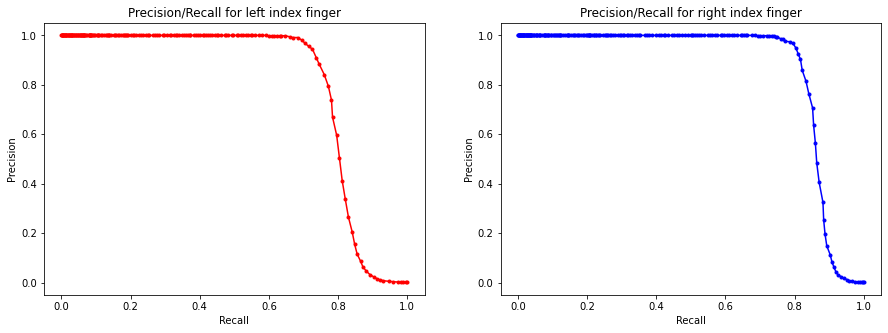

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(Recall_li,Precision_li,color="RED",marker=".",label='PR/RE')
axes[0].set_xlabel("Recall")
axes[0].set_ylabel("Precision")
axes[0].title.set_text("Precision/Recall for left index finger")
axes[1].plot(Recall_ri,Precision_ri,color="Blue",marker=".",label='PR/RE')
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].title.set_text("Precision/Recall for right index finger")
plt.show()

#####Precision recall curves are used when our data has imbalanced classes as most of the metrics suffer from data imbalance problem. Recall tells us what we have missed. If the False negatives increase, recall goes down while Precision on the hand is defined in terms of False positive. It tells us, out of all positively predicted instance, how many are actually positive.

In [ ]:
"""Calculate the Area Under the PR-curve."""
area_li = metrics.auc(Recall_li,Precision_li)
area_ri = metrics.auc(Recall_ri,Precision_ri)
print("Area under PR-curve for left index finger is ", area_li)
print()
print("Area under PR-curve for left index finger is ", area_ri)

Area under PR-curve for left index finger is  0.8034780801507487

Area under PR-curve for left index finger is  0.8627573994779721


In [ ]:
"""Calculate the average precision scores"""
avg_pr_scores_li = average_precision_score(li_genuine_id,li_scores)
avg_pr_scores_ri = average_precision_score(ri_genuine_id,ri_scores)

print("The average precision scores for left index finger are ",avg_pr_scores_li)
print()
print("The average precision scores for right index finger are ",avg_pr_scores_ri)



The average precision scores for left index finger are  0.7988972537365139

The average precision scores for right index finger are  0.8595122882879992


##### The larger the area under the precision-recall curve, the better the performance of a model is.

## Validation of identification  

### Evaluation using CMC curves
In an identification scenario one has a 1-to-many or multi-class classification problem. The performance of such a system is typically measured by the Cumulative Match Characteristic (CMC) curve. This curve plots the experimental probability that a correct identification is returned within the top-x (x=1, ..., N) ranked matching scores. 

<img src="img/CMC.jpg" width="500" height="auto"/>

[Bolle et al.](https://ieeexplore.ieee.org/document/1544394) show that:
> the CMC is also related to the FAR and FRR of a 1:1 matcher, i.e., the matcher that is used to rank the candidates by sorting the scores. This has as a consequence that when a 1:1 matcher is used for identification, that is, for sorting match scores from high to low, the CMC does not offer any additional information beyond the FAR and FRR curves. The CMC is just another way of displaying the data and can be computed from the FAR and FRR.

This paper is not mandatory but those interested can have a look at it.

CMC curves can easily be generated once you have the ranked matching scores for every test sample. In our example we can easily calculate it from the similarity matrix (note that in this very particular case we have only one genuine pair per test sample). 



#### <font color=blue> Task 1.6 Experiment with CMC

* Calculate the Cumulative Matching Characteristic curve (implement this yourself)
* Compute the Rank-1 Recognition Rate.
        
</font>

In [ ]:
"""Calculate the Cumulative Matching Characteristic curve."""
# Hint: don't use a library


def CMC(similarity_matrix, n_ranks):
    copy = similarity_matrix.copy().to_numpy()
    rows,cols = copy.shape
    ranks_count = [0]*n_ranks 
    normalized = [0]*n_ranks
    for i in range(0,rows):
        element = copy[i][i]
        row = list(copy[1])
        row = sorted(row,reverse=True)
        greater_vals = len([i for i in row if i >= element])
        if(greater_vals < n_ranks):
           val = ranks_count[greater_vals]
           val = val+1
           ranks_count[greater_vals] = val
    total_sum = 0
    for i in range(0,n_ranks):
      total_sum = total_sum + ranks_count[i]
      normalized[i] = total_sum/rows
    # 1.1) compute the rank of the column elements (enrollees) for every row (user)
    # 1.2) calculate how frequent each rank occurs on the diagonal (diagonal contains the correct identifications)  
    # 1.3) compute the cumalulative frequency for each rank and normalise the result 
    # 1.4) return the CMC

    return normalized

# 1) compute the CMC for the first ±100 ranks
n_ranks = 100

# 2) plot the probability of recognition in function of the rank
result_ri = CMC(ri_similarity_matrix,n_ranks)
result_li = CMC(li_similarity_matrix,n_ranks)

In [ ]:
ranks = []
for i in range(n_ranks):
    ranks.append(i) 


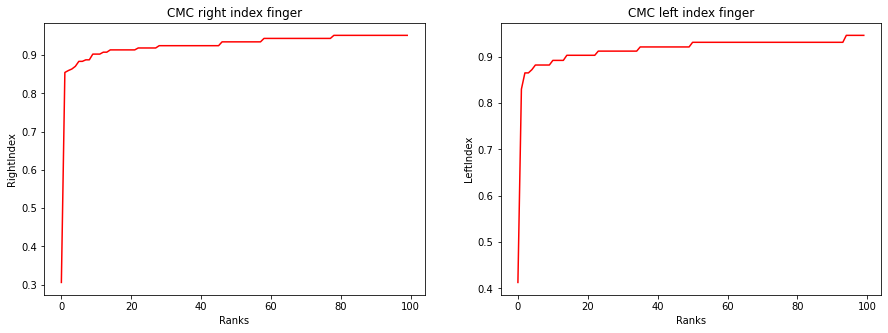

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(ranks,result_ri,color="RED",marker="",label='RightIndex')
axes[0].set_xlabel("Ranks")
axes[0].set_ylabel("RightIndex")
axes[0].title.set_text("CMC right index finger")
axes[1].plot(ranks,result_li,color="RED",marker="",label='LeftIndex')
axes[1].set_xlabel("Ranks")
axes[1].set_ylabel("LeftIndex")
axes[1].title.set_text("CMC left index finger")
plt.show()

In [ ]:

"""compute the Rank-1 Recognition Rate."""
display("Rank-1 recognition rate for right index finger is " + str(result_ri[0]))
display("Rank-1 recognition rate for left index finger is " + str(result_li[0]))

'Rank-1 recognition rate for right index finger is 0.306'

'Rank-1 recognition rate for left index finger is 0.413'

####Rank 1 recognition rate tells us about the percentage of the instaces that have rank 1. In our example, we have 30% for left index finger while 41% for right index finger.

#### <font color=blue> Task 1.7 Evaluate different biometric systems
    
With all above plots and metrics, you can start comparing different biometric systems (same biometric with different implementation, or different biometrics) in an authentication/verification and identification scenario. 
    
* Do this for comparing the left index from the right index finger.
* Do you see any differences in any of the curves or measures?
        
</font>

####This task is already done because we plot the metrics for both fingers while developing ploting things. There are sometimes very small(ignoreable) differences but most of the time results are same. It is hard to know the difference from the curves but one can display the numerical values and notices that there are differences.